2602160750/Bryan Orville Audric

#Function For Majority Voting

In [1]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator,
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        y : array-like, shape = [n_examples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.

        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

# Loading Dataset

In [2]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/Dataset/loan_data.csv')

In [3]:
data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


# Data Visualization

In [4]:
data.shape

(9578, 14)

In [5]:
data.dtypes

credit.policy          int64
purpose               object
int.rate             float64
installment          float64
log.annual.inc       float64
dti                  float64
fico                   int64
days.with.cr.line    float64
revol.bal              int64
revol.util           float64
inq.last.6mths         int64
delinq.2yrs            int64
pub.rec                int64
not.fully.paid         int64
dtype: object

Label Encoding Non Numeric Value into Numeric Value

In [6]:
from sklearn.preprocessing import LabelEncoder

Encoder  = LabelEncoder()

data['purpose'] = Encoder.fit_transform(data['purpose'])

In [7]:
data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,2,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,2,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,2,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


<Axes: xlabel='days.with.cr.line', ylabel='revol.bal'>

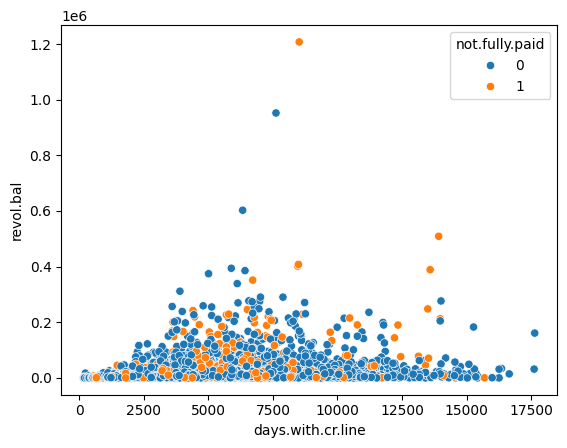

In [8]:
import seaborn as sns

sns.scatterplot(data=data,x='days.with.cr.line',y='revol.bal',hue='not.fully.paid')

<Axes: xlabel='installment', ylabel='days.with.cr.line'>

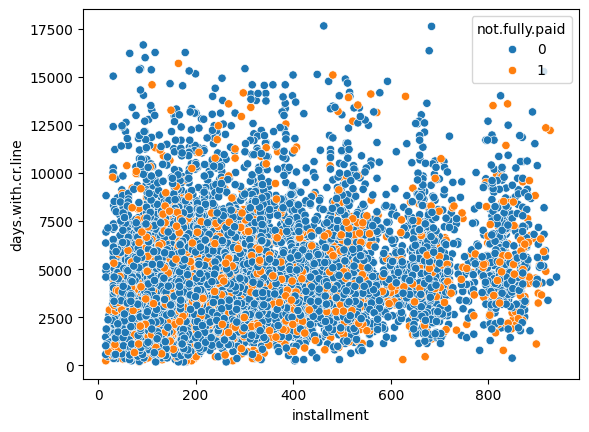

In [9]:
sns.scatterplot(data=data,x='installment',y='days.with.cr.line',hue='not.fully.paid')

<Axes: ylabel='int.rate'>

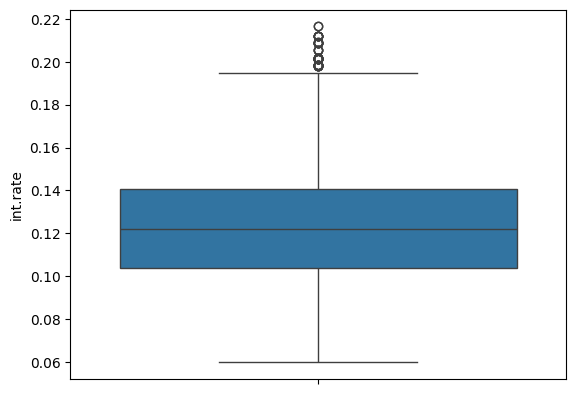

In [10]:
sns.boxplot(data=data['int.rate'])

<Axes: ylabel='installment'>

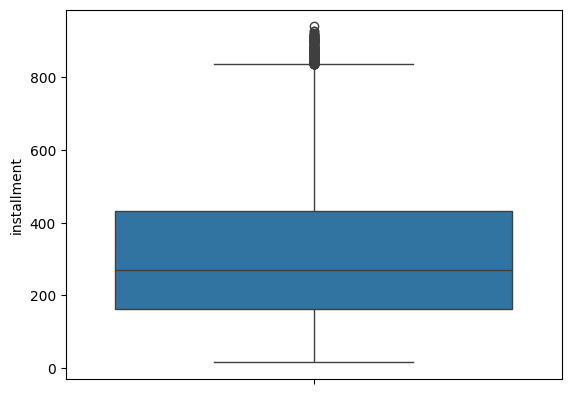

In [11]:
sns.boxplot(data=data['installment'])

<Axes: ylabel='log.annual.inc'>

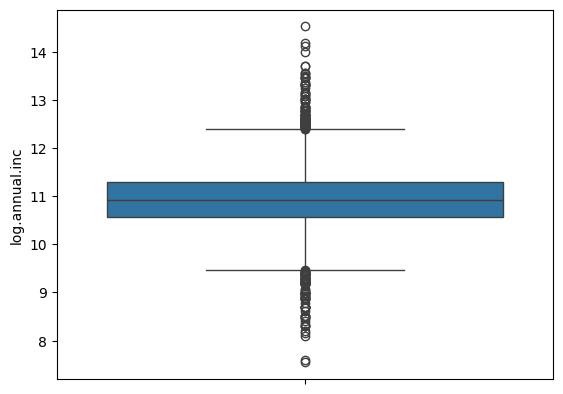

In [12]:
sns.boxplot(data=data['log.annual.inc'])

<Axes: ylabel='dti'>

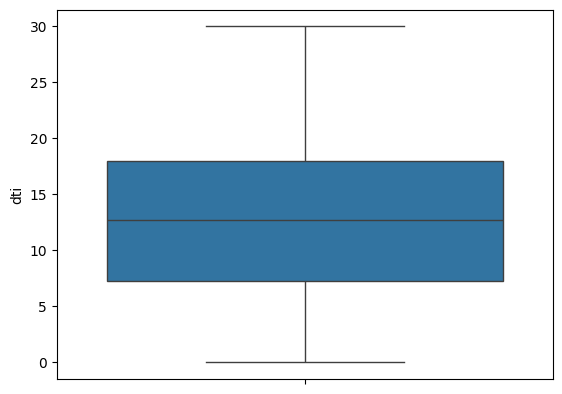

In [13]:
sns.boxplot(data=data['dti'])

<Axes: ylabel='fico'>

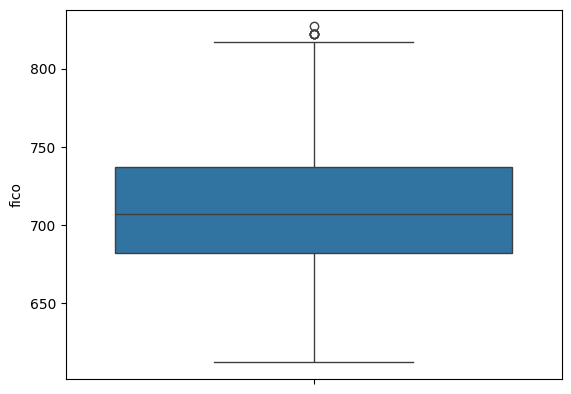

In [14]:
sns.boxplot(data=data['fico'])

<Axes: ylabel='days.with.cr.line'>

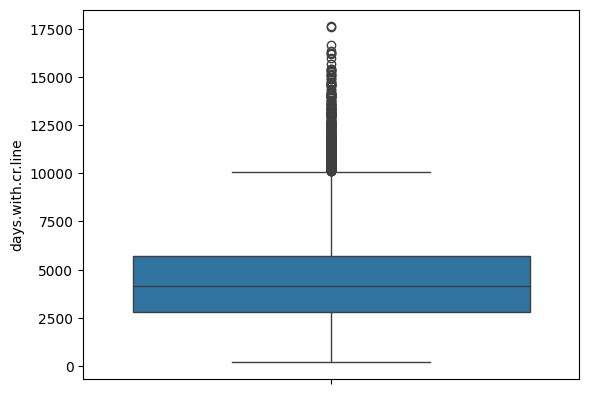

In [15]:
sns.boxplot(data=data['days.with.cr.line'])

<Axes: ylabel='revol.bal'>

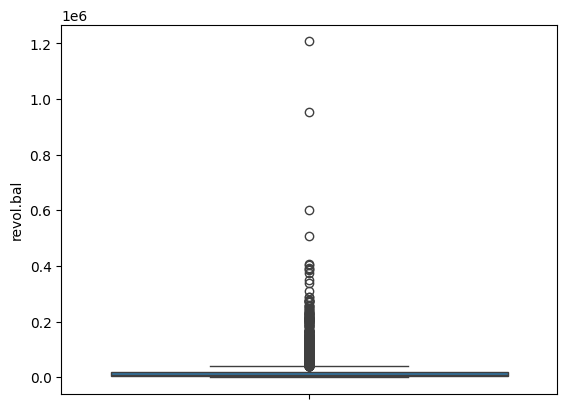

In [16]:
sns.boxplot(data=data['revol.bal'])

<Axes: ylabel='revol.util'>

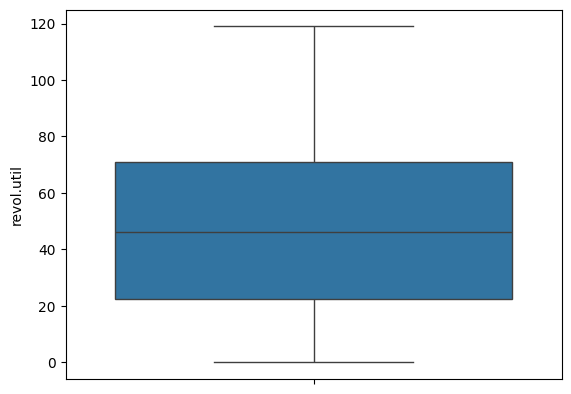

In [17]:
sns.boxplot(data=data['revol.util'])

<Axes: >

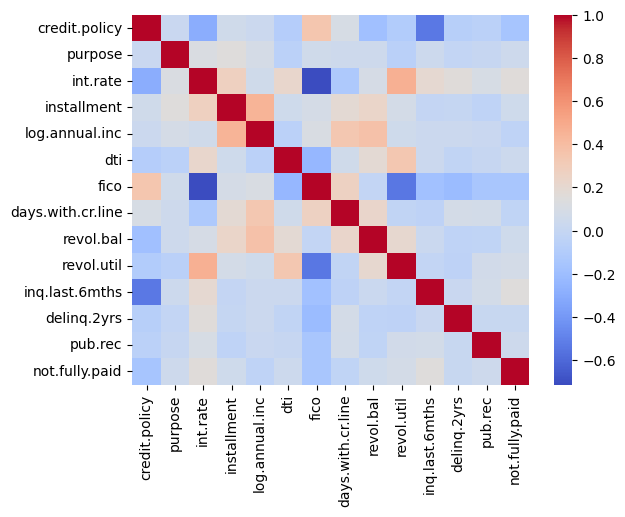

In [18]:
sns.heatmap(data=data.corr(),cmap='coolwarm')

# Preprocessing

Checking Missing Value

In [19]:
data.isnull().sum()

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

Feature Selection

In [20]:
from scipy.stats import pearsonr

dfcopy = data.copy()
dfcopy = dfcopy.drop(columns=['not.fully.paid'])
features = list(dfcopy.columns)

selected_features = []

for feature in features:
  correlation_coefficient, pvalue = pearsonr(dfcopy[feature],data['not.fully.paid'])

  if abs(correlation_coefficient)>0.1 and pvalue <0.05:
    selected_features.append(feature)

Feature selected

In [21]:
selected_features

['credit.policy', 'int.rate', 'fico', 'inq.last.6mths']

In [22]:
selected_features.append('not.fully.paid')

columns = selected_features

data = data[columns]

data.head()

,credit.policy,int.rate,fico,inq.last.6mths,not.fully.paid
0,1,0.1189,737,0,0
1,1,0.1071,707,0,0
2,1,0.1357,682,1,0
3,1,0.1008,712,1,0
4,1,0.1426,667,0,0


Removing Outlier

In [23]:
data.shape

(9578, 5)

In [24]:
import numpy as np
Q1 = data['int.rate'].quantile(0.25)
Q3 = data['int.rate'].quantile(0.75)

IQR = Q3-Q1

lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

lower_array = np.where(data['int.rate']<lower)[0]
upper_array = np.where(data['int.rate']>upper)[0]

data.drop(index=lower_array,inplace=True)
data = data.reset_index(drop=True)
data.drop(index=upper_array,inplace=True)
data= data.reset_index(drop=True)


<ipython-input-24-ae4321101053>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(index=lower_array,inplace=True)


In [25]:
data.shape

(9527, 5)

In [26]:
import numpy as np
Q1 = data['fico'].quantile(0.25)
Q3 = data['fico'].quantile(0.75)

IQR = Q3-Q1

lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

lower_array = np.where(data['fico']<lower)[0]
upper_array = np.where(data['fico']>upper)[0]

data.drop(index=lower_array,inplace=True)
data = data.reset_index(drop=True)
data.drop(index=upper_array,inplace=True)
data= data.reset_index(drop=True)

In [27]:
data.shape

(9521, 5)

Standardizing fico value

In [28]:
from sklearn.preprocessing import StandardScaler

df = data.copy()
Scaler = StandardScaler()

df = Scaler.fit_transform(df)
df = pd.DataFrame(df,columns=[columns])



In [29]:
data['fico'] = df['fico']

In [30]:
data.head()

,credit.policy,int.rate,fico,inq.last.6mths,not.fully.paid
0,1,0.1189,0.687683,0,0
1,1,0.1071,-0.104377,0,0
2,1,0.1357,-0.764427,1,0
3,1,0.1008,0.027633,1,0
4,1,0.1426,-1.160456,0,0


Using Over-Sampling Method to balance the dataset to bring up the minority class up

SMOTE is used, which is a technique in classification problems where the minority class is significantly smaller than the majority class. The technique works by selecting an example from the minority class and finding its k nearest neighbors. It then creates new synthetic examples by randomly interpolating the attributes of the selected examples and adding them to the dataset.

Source: https://medium.com/@daniele.santiago/balancing-imbalanced-data-undersampling-and-oversampling-techniques-in-python-7c5378282290



In [31]:
from imblearn.over_sampling import SMOTE
x = data.drop(columns=['not.fully.paid'])
y = data['not.fully.paid']

Sampling = SMOTE()
x_resampled,y_resampled = Sampling.fit_resample(x,y)

In [32]:
x_resampled.shape

(16012, 4)

In [33]:
y_resampled.shape

(16012,)

# Splitting Dataset 70:30



In [34]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x_resampled,y_resampled,stratify=y_resampled,random_state=42,test_size=0.3)

# Modeling

Decision Tree

In [35]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()

DT.fit(x_train,y_train)

DT_Pred = DT.predict(x_test)

Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()

RF.fit(x_train,y_train)

RF_Pred = RF.predict(x_test)

AdaBoost

In [37]:
from sklearn.ensemble import AdaBoostClassifier

ABC = AdaBoostClassifier()
ABC.fit(x_train,y_train)

ABC_Pred = ABC.predict(x_test)

Majority Voting

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2',
                          C=0.001,
                          solver='lbfgs',
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

mv_clf.fit(x_train,y_train)
mv_pred = mv_clf.predict(x_test)

# Evaluation

Decision Tree

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("Decision Tree")
print(classification_report(y_test,DT_Pred))

Decision Tree
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      2402
           1       0.81      0.78      0.79      2402

    accuracy                           0.80      4804
   macro avg       0.80      0.80      0.80      4804
weighted avg       0.80      0.80      0.80      4804



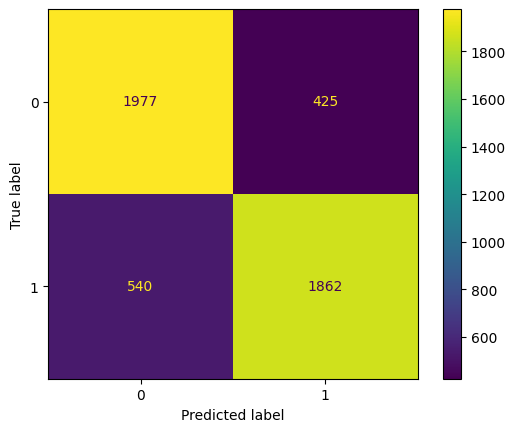

In [40]:
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,DT_Pred),display_labels=DT.classes_)
display.plot()

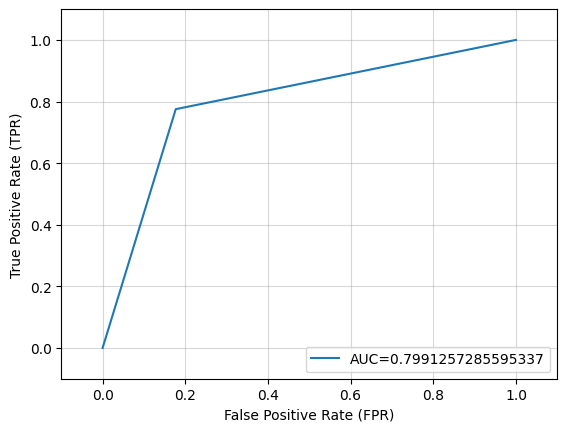

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score

fpr,tpr,_ = roc_curve(y_test,DT_Pred)
auc = roc_auc_score(y_test,DT_Pred)

plt.plot(fpr,tpr,label='AUC='+str(auc))
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc=4)
plt.show()

Random Forest

In [42]:
print("Random Forest")
print(classification_report(y_test,RF_Pred))

Random Forest
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      2402
           1       0.76      0.75      0.75      2402

    accuracy                           0.76      4804
   macro avg       0.76      0.76      0.76      4804
weighted avg       0.76      0.76      0.76      4804



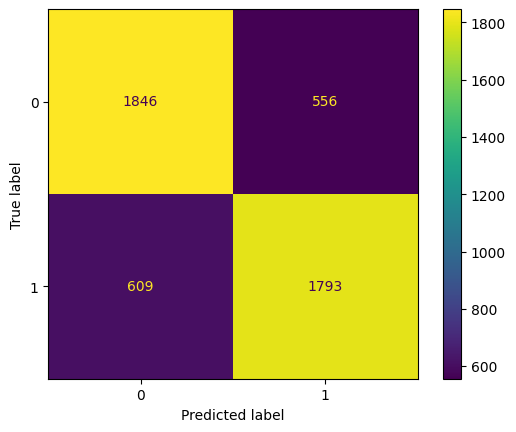

In [43]:
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,RF_Pred),display_labels=RF.classes_)
display.plot()

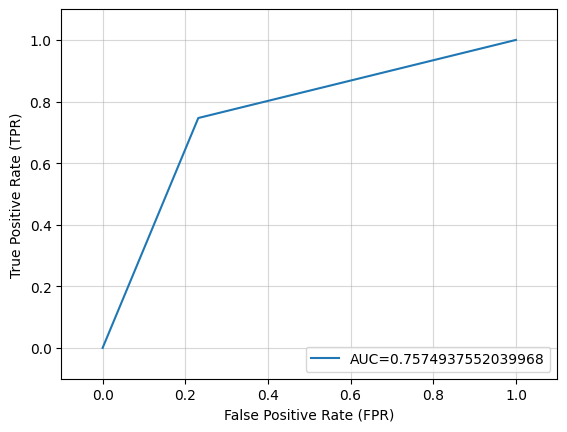

In [44]:
fpr,tpr,_ = roc_curve(y_test,RF_Pred)
auc = roc_auc_score(y_test,RF_Pred)

plt.plot(fpr,tpr,label='AUC='+str(auc))
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc=4)
plt.show()

ADA Boost

In [45]:
print("ADA Boost")
print(classification_report(y_test,ABC_Pred))

ADA Boost
              precision    recall  f1-score   support

           0       0.64      0.59      0.61      2402
           1       0.62      0.66      0.64      2402

    accuracy                           0.63      4804
   macro avg       0.63      0.63      0.63      4804
weighted avg       0.63      0.63      0.63      4804



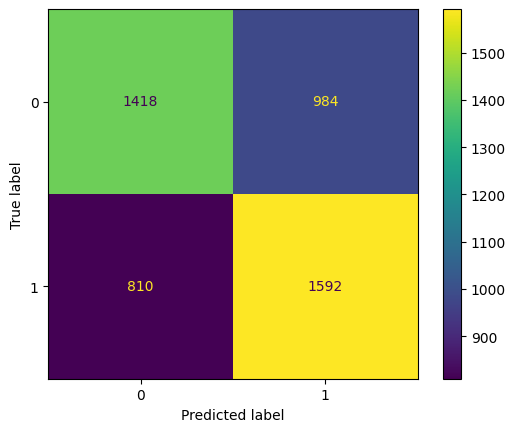

In [46]:
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,ABC_Pred),display_labels=ABC.classes_)
display.plot()

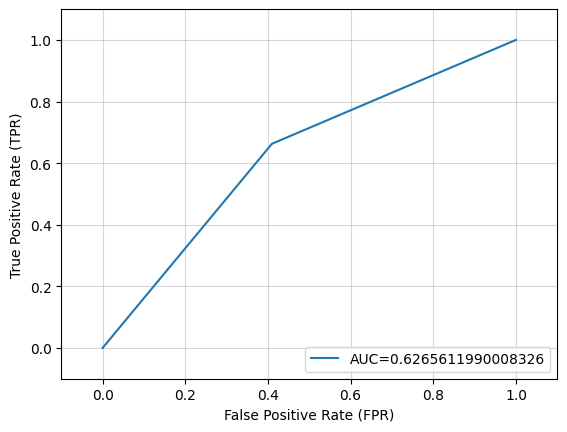

In [47]:
fpr,tpr,_ = roc_curve(y_test,ABC_Pred)
auc = roc_auc_score(y_test,ABC_Pred)

plt.plot(fpr,tpr,label='AUC='+str(auc))
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc=4)
plt.show()

Majority Voting

In [48]:
print("Majority Voting")
print(classification_report(y_test,mv_pred))

Majority Voting
              precision    recall  f1-score   support

           0       0.75      0.51      0.61      2402
           1       0.63      0.83      0.72      2402

    accuracy                           0.67      4804
   macro avg       0.69      0.67      0.66      4804
weighted avg       0.69      0.67      0.66      4804



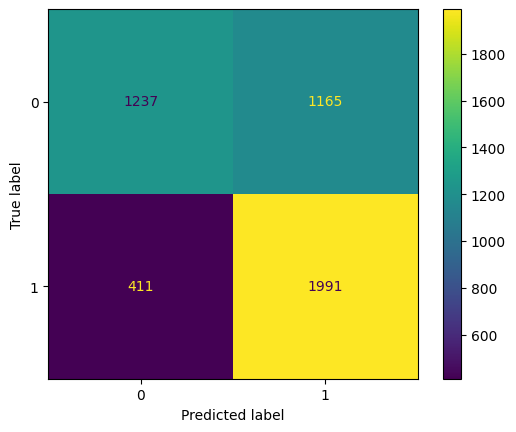

In [49]:
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,mv_pred))
display.plot()

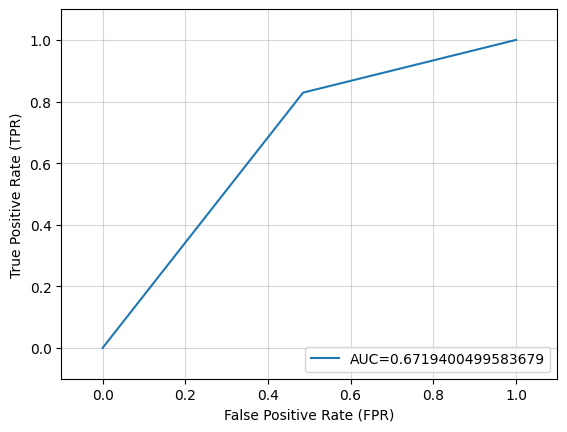

In [50]:
fpr,tpr,_ = roc_curve(y_test,mv_pred)
auc = roc_auc_score(y_test,mv_pred)

plt.plot(fpr,tpr,label='AUC='+str(auc))
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc=4)
plt.show()

# Insights

There appears to be a huge amount of false positive from  Majority Voting Model prediction compared to other classifier like Decision Tree, Random Forest and ADA Boost. However, ADA Boost has the lowest accuracy amongst the four classifier model used. On the other hand, Decision Tree has the highest accuracy compared to other classifier Models. This issue of having relatively mediocre and low accuracy is likely due to the imbalance of dataset. Even with the attempt of oversampling method to balance out the dataset, the accuracy cannot reach a number above 80%